<h2 id='part1'>Section 1: Business Understanding</h2>
I'm planning a trip to seattle but I have no preferred season or appartment yet. With the help of the open source data set from AirBnB I want to understand, in which season most people visit Seattle. Secondly, I want to book a cheep house, that costs at least 50$ per night and is available for 13 consecutive nights.

<h4 id='part1'>My Questions: </h4>

1) Do people favour specific seasons?

2) Which season is cheepest?

3) Which of that cheep houses are available for 2 weeks at least?

<h2 id='part1'>Section 2: Data Understanding</h2>

In order to get a better understanding of the data we will be looking at, let's take a look at some of the characteristics of the dataset.
First, let's read in the data and necessary libraries.

<h3 id='part1'>Load libraries:</h3>
First we need to load all required python packages.

In [100]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


<h3 id='part1'>Gather data:</h3>
In a next step I will read all the data files, that I need for my analysis.

In [101]:

df_calendar = pd.read_csv('./data/calendar.csv')


<h3 id='part1'>Assess our data:</h3>
Now we will have a look into our data to see which information are available. Further we will have a look at the quality of data to decide if data cleaning steps required.

In [102]:
# Shape of my data
print('Amount of data:\n',df_calendar.shape,'\n')

# How many listings in total? 
total_listings = df_calendar['listing_id'].nunique()
print('Number of unique listings: ', total_listings ,'\n')

# Which data types?
print('Data types: \n', df_calendar.dtypes,'\n')

# Head of data set
print('Available columns with examples:\n',df_calendar.head(),'\n')


Amount of data:
 (1393570, 4) 

Number of unique listings:  3818 

Data types: 
 listing_id     int64
date          object
available     object
price         object
dtype: object 

Available columns with examples:
    listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN 



We are handling a data set with around 1.3m rows and 4 columns. In that columns we have details per listing_id (house) in terms of availability and price. We see the availability flag per date and the price if the house is available. We are dealing with object columns. It would be easier for the analysis to split the date into day, month and year. In terms of the price, it would be much better to have it as integer to be able to make calculations.

In [103]:
print('Overview about the date column:\n',df_calendar['date'].describe(),'\n')
print('First date: ', sorted(df_calendar['date'].unique())[0],' and last date: ', sorted(df_calendar['date'].unique())[-1],'\n')

print('Overview about the available column:\n',df_calendar['available'].describe(),'\n')

print('Overview about the price column:\n',df_calendar['price'].describe(),'\n')
print('How many NULL values in price column: ',df_calendar['price'].isnull().sum())

#print('Max price: ', sorted(df_calendar[df_calendar.price.notnull()]['price'].unique()))#[0],' and min price: ', sorted(df_calendar[df_calendar.price.notnull()]['price'].unique())[-1], '\n' )


Overview about the date column:
 count        1393570
unique           365
top       2016-03-04
freq            3818
Name: date, dtype: object 

First date:  2016-01-04  and last date:  2017-01-02 

Overview about the available column:
 count     1393570
unique          2
top             t
freq       934542
Name: available, dtype: object 

Overview about the price column:
 count      934542
unique        669
top       $150.00
freq        36646
Name: price, dtype: object 

How many NULL values in price column:  459028


The describe function gives us an overview about the columns: 
1) The date columns includes 365 unique entries, starting from 2016-01-04 to 2017-01-02. I will consider only the days from year 2016 later.
2) We have in the availabilty flag 934542 with available = t (=true) and 459028 with available = f (=false). 
3) In the price column I can see, that in case a house is not available, I get a NULL. Dealing with a price as string including $ sign and separators is very hard. So I will transform it to an integer. NULL values are actually no problem in my case, but I will clean them as well.

<h2 id='part1'>Section 3: Data Preparation</h2>
I will need to clean up the NULL values in the price column and transform it to an integer. Because just the prices of not-available houses with availabile = f are filled with NULL I will replace them with 0, in order to be able to apply proper calculations. 

Additionally, I will split the date column into Year, Month and Day.

In [104]:
# Split Date columns:
df_calendar[['Year','Month','Day']] = df_calendar['date'].str.split(pat="-", expand = True)

# Transform price:
df_calendar['price'] = df_calendar['price'].fillna("$0.00")
df_calendar['price_number'] = df_calendar['price'].str[1:-3]
df_calendar['price_number']= df_calendar['price_number'].str.replace(r'\D', '').astype(int) 

print(df_calendar.head())
print(df_calendar.dtypes)



   listing_id        date available   price  Year Month Day  price_number
0      241032  2016-01-04         t  $85.00  2016    01  04            85
1      241032  2016-01-05         t  $85.00  2016    01  05            85
2      241032  2016-01-06         f   $0.00  2016    01  06             0
3      241032  2016-01-07         f   $0.00  2016    01  07             0
4      241032  2016-01-08         f   $0.00  2016    01  08             0
listing_id       int64
date            object
available       object
price           object
Year            object
Month           object
Day             object
price_number     int32
dtype: object


Great, now we have our data clean and can start our analysis.

<h2 id='part1'>Section 4: Evaluate data</h2>
<h3 id='part1'>Question 1:</h3>
Do people favour specific seasons? 

Do get a better idea, which season is best to visit Seattle, I want to have a look, in which months people have mostly booked AirBnB houses in 2016. 

   Month  Avg_Availability
0     01          0.554133
6     07          0.627097
7     08          0.645051
1     02          0.662208
3     04          0.663847
5     06          0.674384
8     09          0.674402
4     05          0.675670
9     10          0.696514
2     03          0.709187
10    11          0.713986
11    12          0.735573


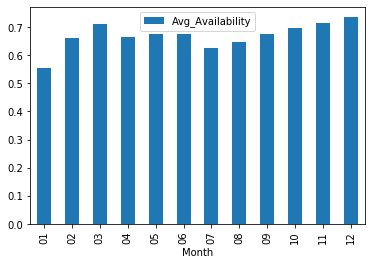

In [105]:
# How is the portion of available houses per month? 
availability = df_calendar.groupby('date').available.value_counts().reset_index(name='Count')
availability['Portion']=availability.Count/total_listings
availability[['Year','Month','Day']] = availability['date'].str.split(pat="-", expand = True)
Year_available = availability[(availability.available == 't') & (availability.Year=='2016')][['date','Month','Day','Portion']]
Month_available = Year_available.groupby('Month').Portion.mean().reset_index(name='Avg_Availability')
print(Month_available.sort_values(by = 'Avg_Availability'))

Month_available.plot(x='Month', y='Avg_Availability', kind='bar') 
plt.show()

The most preferred seasons in 2016 to visit Seattle was at the beginning of the year in January and Feruary or in summer in July and August.

Let's have a look into the different price ranges between Winter (January, February) and Summer (July, August).

<h3 id='part1'>Question 2:</h3>
In which of these two season can I get a cheeper house?  

In [106]:
# Define separate data frame for winter
df_beginning = df_calendar[(df_calendar.Year == '2016') & ((df_calendar.Month == '01') | (df_calendar.Month == '02')) & (df_calendar.available == 't')]

# What is the average price of the available houses in beginning of year (Jan, Feb)?
prices_janfeb = df_beginning.groupby('price')['listing_id'].nunique().reset_index(name='no_listings')
prices_janfeb['price_number'] = prices_janfeb['price'].str[1:-3].replace('1,000','1000').astype(int)
prices_janfeb = prices_janfeb.sort_values('price_number', ascending = True)

# Create bins to group prices and count
bins = [0, 50, 100, 150, 200, 1500]
prices_janfeb['binned'] = pd.cut(prices_janfeb['price_number'], bins)
print('Price ranges and counts in Winter: \n', prices_janfeb.groupby('binned')['no_listings'].sum())

Price ranges and counts in Winter: 
 binned
(0, 50]        1096
(50, 100]      4394
(100, 150]     3399
(150, 200]     1290
(200, 1500]     994
Name: no_listings, dtype: int64


In [107]:
# Define separate data frame for summer
df_summer = df_calendar[(df_calendar.Year == '2016') & ((df_calendar.Month == '07') | (df_calendar.Month == '08')) & (df_calendar.available == 't')]

# What is the average price of the available houses in summer?
prices_julaug = df_summer.groupby('price')['listing_id'].nunique().reset_index(name='no_listings')
prices_julaug['price_number'] = prices_julaug['price'].str[1:-3].replace('1,000','1000').replace('1,199','1199').replace('1,240','1240').replace('1,250','1250').astype(int)
prices_julaug = prices_julaug.sort_values('price_number', ascending = True)

# Create bins to group prices and count
bins = [0, 50, 100, 150, 200, 1500]
prices_julaug['binned'] = pd.cut(prices_julaug['price_number'], bins)
print('Price ranges and counts in Summer: \n', prices_julaug.groupby('binned')['no_listings'].sum())


Price ranges and counts in Summer: 
 binned
(0, 50]         225
(50, 100]      1487
(100, 150]     1119
(150, 200]      964
(200, 1500]    2060
Name: no_listings, dtype: int64


Generally in winter are more cheep houses available than in summer. I can select out of 1096 houses for less than 50$. In summer I can select out of 225 houses for less than 50$. 

I decide to visit Seattle in winter because I have a higher number of available houses with a price lower than 50$.


<h3 id='part1'>Question 3:</h3>
Which of that cheep houses are available for 2 weeks at least? 

In [114]:
"""
Filter on cheap houses first
"""
df_cheep = df_beginning[df_beginning['price_number'] <=50]

""" 
Create list of available days per listing
"""

df_cheep = df_cheep.sort_values(['listing_id', 'date'])
df_cheep_grouped = df_cheep.groupby(['listing_id','Month'])['Day'].agg(['unique']).reset_index()
df_cheep_grouped_days = df_cheep.groupby(['listing_id','Month'])['Day'].agg(['nunique']).reset_index()
df_cheep_grouped['nunique'] = df_cheep_grouped_days['nunique']
print('Example listing and list of available days: \n', df_cheep_grouped.head(), '\n')

"""
Determine consecutive days and count nights
"""
# Function to count ones in array
def count_numbers(numbers):
    """
    Input: [0,0,0,0,1,1,0,1,1,1,1,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0]
    Output: [2, 4, 7, 1]
    """
    results = []
    counter = 0
    if all(p == 1 for p in numbers):
        results.append(len(numbers))
    else:
        for number in numbers:
            if number == 1:
                counter += 1
            elif (number != 1) and counter:
                results.append(counter)
                counter = 0
    return results


two_weeks_available = []

for i in enumerate(df_cheep_grouped["unique"]):
    array = i[1].astype(int)

    day_diff = []
    for val in range(len(array)-1):
        #calculate difference between numbers to determine number of nights
        day_diff.append(array[val+1] - array[val])

    """ 
    Use function for counting ones to determine how many nights are between consecutive days
    if element2-element1 = 1 -> 1 night in between and then it is counted
    """    
    count_consecutive_nights = count_numbers(day_diff)
   

    """ 
    Return index if house is available for at least 13 consecutive nights (Output: list of indexes from initial dataframe)
    """
    if np.any(np.asarray(count_consecutive_nights) >= 13):
        two_weeks_available.append(i[0])
    

available_houses = df_cheep_grouped.iloc[two_weeks_available]

final_list_listings = available_houses['listing_id'].unique()
# Available houses for at least two weeks: 
available_houses.head()


Example listing and list of available days: 
    listing_id Month                                            unique  nunique
0        5682    01          [11, 12, 13, 14, 15, 19, 20, 26, 27, 31]       10
1        5682    02                              [01, 02, 03, 04, 09]        5
2       14386    01                  [06, 07, 08, 09, 10, 11, 12, 13]        8
3       20928    01                                              [06]        1
4       43373    01  [13, 14, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28]       12 



,listing_id,Month,unique,nunique
6,149489,01,"[04, 05, 06, 07, 08, 09, 10, 11, 12, 13, 14, 1...",28
7,149489,02,"[01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 1...",29
9,226677,01,"[05, 06, 07, 08, 09, 10, 11, 12, 13, 14, 15, 1...",27
10,226677,02,"[01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 1...",29
13,444221,01,"[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 2...",14


As a result I got a list of 218 houses, that I can visit in the most favoured season, in winter, for a price less than 50$ per night and are available for at least 13 consecutive nights.